In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import datetime
import time
from sklearn.ensemble import RandomForestRegressor
import warnings
from sklearn.model_selection import train_test_split
from model import *
from rgf.sklearn import RGFClassifier
import xgbfir
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm  import LGBMClassifier

In [2]:
%load_ext autoreload
%autoreload 2
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
# 关闭 SettingWithCopyWarning 
pd.set_option('mode.chained_assignment', None)

In [3]:
df = pd.read_csv('data.csv', encoding='gbk')

In [4]:
df.shape

(4754, 90)

In [5]:
df.head()

,Unnamed: 0,custid,trade_no,bank_card_no,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,...,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
0,5,2791858,20180507115231274000000023057383,卡号1,0.01,0.99,0,0.90,0.55,0.313,...,2900.0,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0
1,10,534047,20180507121002192000000023073000,卡号1,0.02,0.94,2000,1.28,1.00,0.458,...,3500.0,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0
2,12,2849787,20180507125159718000000023114911,卡号1,0.04,0.96,0,1.00,1.00,0.114,...,1600.0,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0
3,13,1809708,20180507121358683000000388283484,卡号1,0.00,0.96,2000,0.13,0.57,0.777,...,3200.0,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0
4,14,2499829,20180507115448545000000388205844,卡号1,0.01,0.99,0,0.46,1.00,0.175,...,2300.0,1630.0,8300.0,79.0,2.0,2.0,8400.0,8250.0,22.0,120.0


In [6]:
x = df.drop('status', axis=1)
y = df['status']

In [7]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2018)

# 数据类型分析

In [8]:
# train = pd.concat((x_train, y_train), axis=1)

In [9]:
# train_test = pd.concat((x_train, x_test))

In [10]:
train_test = x

In [11]:
train_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Columns: 89 entries, Unnamed: 0 to loans_latest_day
dtypes: float64(70), int64(12), object(7)
memory usage: 3.2+ MB


原数据中数值型特征有 82 个，字符串类型特征有 7 个，多数特征缺失值不是特别多，student_feature 缺失值较多。

In [12]:
train_test.shape

(4754, 89)

In [13]:
train_test.describe()

,Unnamed: 0,custid,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,...,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
count,4754.000000,4.754000e+03,4752.000000,4752.000000,4754.000000,4751.000000,4752.000000,4752.000000,4752.000000,4746.000000,...,4457.000000,4457.000000,4457.000000,4457.000000,4457.000000,4457.000000,4457.000000,4457.000000,4450.000000,4457.000000
mean,6008.414178,1.690993e+06,0.021806,0.901294,1940.197728,14.160674,0.804411,0.365425,17.502946,29.029920,...,3390.038142,1820.357864,9187.009199,76.042630,4.732331,5.227507,16153.690823,8007.696881,24.112809,55.181512
std,3452.071428,1.034235e+06,0.041527,0.144856,3923.971494,694.180473,0.196920,0.170196,4.475616,22.722432,...,1474.206546,583.418291,7371.257043,14.536819,2.974596,3.409292,14301.037628,5679.418585,37.725724,53.486408
min,5.000000,1.140000e+02,0.000000,0.000000,0.000000,0.000000,0.120000,0.033000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,-2.000000
25%,3106.000000,7.593358e+05,0.010000,0.880000,0.000000,0.615000,0.670000,0.233000,15.000000,16.000000,...,2300.000000,1535.000000,4800.000000,77.000000,2.000000,3.000000,7800.000000,4737.000000,5.000000,10.000000
50%,6006.500000,1.634942e+06,0.010000,0.960000,500.000000,0.970000,0.860000,0.350000,17.000000,23.000000,...,3100.000000,1810.000000,7700.000000,79.000000,4.000000,5.000000,13800.000000,7050.000000,14.000000,36.000000
75%,8999.000000,2.597905e+06,0.020000,0.990000,2000.000000,1.600000,1.000000,0.480000,20.000000,32.000000,...,4300.000000,2100.000000,11700.000000,80.000000,7.000000,7.000000,20400.000000,10000.000000,24.000000,91.000000
max,11992.000000,4.004694e+06,1.000000,1.000000,68000.000000,47596.740000,1.000000,0.941000,42.000000,285.000000,...,10000.000000,6900.000000,87100.000000,87.000000,18.000000,20.000000,266400.000000,82800.000000,360.000000,323.000000


In [14]:
train_test.describe(include='O')

,trade_no,bank_card_no,reg_preference_for_trad,source,id_name,latest_query_time,loans_latest_time
count,4754,4754,4752,4754,4478,4450,4457
unique,4754,1,5,1,4309,207,232
top,20180507124855519000000023107667,卡号1,一线城市,xs,李杰,2018-04-14,2018-05-03
freq,1,4754,3403,4754,5,423,134


In [15]:
y.mean()

0.2509465713083719

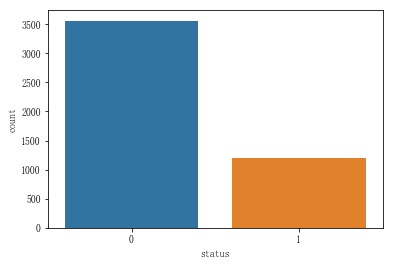

In [16]:
sns.countplot(y)

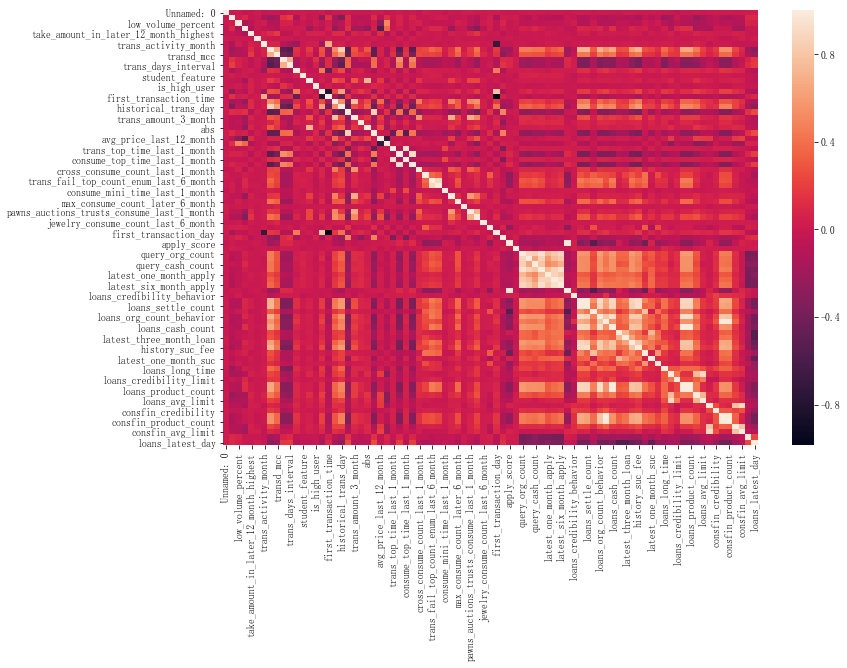

In [17]:
corr_mat = df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_mat)

相关性较强的特征集中在关于下半部分

# 无关特征删除

## 类别特征

### bank_card_no 和 source

bank_card_no 和 source unique 等于 1，删除

In [18]:
train_test.drop(['bank_card_no', 'source'], axis=1, inplace=True)

### trade_no

In [19]:
train_test['trade_no'].head(10)

0    20180507115231274000000023057383
1    20180507121002192000000023073000
2    20180507125159718000000023114911
3    20180507121358683000000388283484
4    20180507115448545000000388205844
5    20180507121233054000000388275132
6    20180507121931540000000388298915
7    20180507124659235000000023105807
8    20180507115855621000000388224458
9    20180504155156296000000021138084
Name: trade_no, dtype: object

In [20]:
def parse_trade_no(array):
    lst = [array[:4], array[4:6], array[6:8], array[-10:]]
    return lst

In [21]:
tradeno_df = pd.DataFrame(train_test['trade_no'].apply(parse_trade_no).values.tolist(), columns=['tradeno_year', 'tradeno_month', 'tradeno_day', 'tradeno_id'])

In [22]:
tradeno_df.describe()

,tradeno_year,tradeno_month,tradeno_day,tradeno_id
count,4754,4754,4754,4754
unique,1,1,3,4754
top,2018,05,07,0388261109
freq,4754,4754,3682,1


In [23]:
tradeno_df['tradeno_day'].value_counts()

07    3682
04    1062
08      10
Name: tradeno_day, dtype: int64

trade_no 字段像个 id 字段，假设前 8 位是年月日信息，可以看出 trade_no 均是在 2018 年 5 月份，tradeno_id 各不相同，保留 tradeno_day，其他的信息删除。

In [24]:
train_test = pd.concat((train_test.drop('trade_no', axis=1), tradeno_df['tradeno_day']), axis=1)

In [25]:
train_test['tradeno_day'].value_counts()

07    3682
04    1062
08      10
Name: tradeno_day, dtype: int64

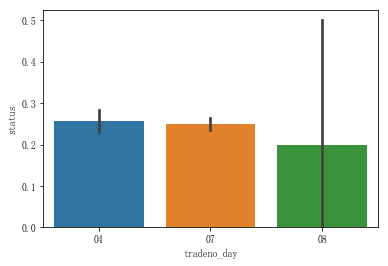

In [26]:
sns.barplot(data=pd.concat((train_test.loc[:x.shape[0]], y), axis=1), x='tradeno_day', y='status')

### id_name

找出出现次数比较多的人名，看看逾期率

In [27]:
idname_count=train_test['id_name'].value_counts()
idname_count = idname_count[idname_count>=4]
idn_df = train_test[train_test['id_name'].isin(idname_count.index)]

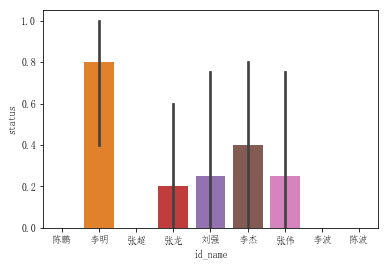

In [28]:
sns.barplot(data=pd.concat((idn_df, y), axis=1), x='id_name', y='status')

李明这个人逾期率挺高的，重点提出来作为类别变量

In [29]:
train_test['is_Li_Ming'] = (df['id_name'] == '李明').apply(int)
train_test.drop('id_name', inplace=True, axis=1)

## 数值特征

In [30]:
value_cols = train_test.describe().columns

In [31]:
train_test[value_cols].nunique().describe()

count      83.000000
mean      486.650602
std      1051.987056
min         2.000000
25%        25.000000
50%        65.000000
75%       222.500000
max      4754.000000
dtype: float64

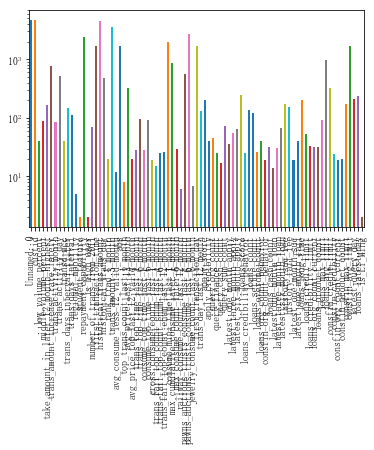

In [32]:
train_test[value_cols].nunique().plot(kind='bar', logy=True)

In [33]:
print('数值特征 unique < 10 个数：', len(train_test[value_cols].columns[train_test[value_cols].nunique()<10]))
print('数值特征 unique < 20 个数：', len(train_test[value_cols].columns[train_test[value_cols].nunique()<20]))
print('数值特征 unique < 30 个数：', len(train_test[value_cols].columns[train_test[value_cols].nunique()<30]))

数值特征 unique < 10 个数： 7
数值特征 unique < 20 个数： 15
数值特征 unique < 30 个数： 27


In [34]:
print('全部为 unique 的特征', train_test[value_cols].columns[train_test[value_cols].nunique()==len(train_test)])

全部为 unique 的特征 Index(['Unnamed: 0', 'custid'], dtype='object')


从 unique 数量来讲，没有 unique == 1 的情况，先不予删除。

### custid

custid 范围中 100~400W，如果假设注册越早，id 越小，看一下 id 大小与逾期率的关系。

In [35]:
custid_range = [1, 1e4, 1e5, 1e6, 2.5e6, 5e6]

In [36]:
train_test['cust_id_bin'] = pd.cut(train_test['custid'], bins=custid_range, labels=[str(i) for i in custid_range][:-1]).astype('float')
train_test.drop('custid', axis=1, inplace=True)

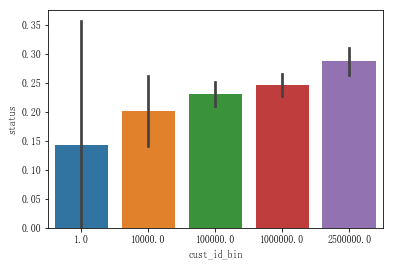

In [37]:
sns.barplot(data=pd.concat((train_test, y),axis=1), x='cust_id_bin', y='status')

正如猜想的一样，id 越小，逾期率越低，可能原因是越最近注册的，是新用户，紧急用钱，越可能逾期。先保留 id 这个特征。

### Unnamed: 0

In [38]:
sum(train_test['Unnamed: 0'].diff(1)>0)

4753

In [39]:
len(train_test)

4754

Unnamed: 0 这个特征数值是递增的，删除

In [40]:
train_test.drop('Unnamed: 0', axis=1, inplace=True)

# 数据类型转换

In [41]:
train_test.describe(include='O')

,reg_preference_for_trad,latest_query_time,loans_latest_time,tradeno_day
count,4752,4450,4457,4754
unique,5,207,232,3
top,一线城市,2018-04-14,2018-05-03,07
freq,3403,423,134,3682


## reg_preference_for_trad

In [42]:
train_test['reg_preference_for_trad'].value_counts()

一线城市    3403
三线城市    1064
境外       150
二线城市     131
其他城市       4
Name: reg_preference_for_trad, dtype: int64

城市之间存在大小差别，采用自然数编码

In [43]:
city_map = {'一线城市':1, '二线城市':2, '三线城市':3, '其他城市':0, '境外':5}

In [44]:
train_test['reg_preference_for_trad'] = train_test['reg_preference_for_trad'].map(city_map)

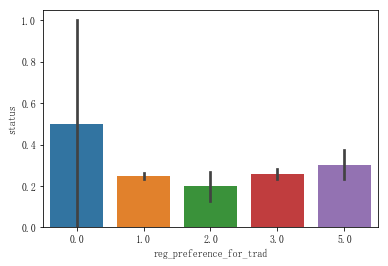

In [45]:
sns.barplot(data=pd.concat((train_test, y), axis=1), x='reg_preference_for_trad', y='status')

## tradeno_day

In [46]:
train_test['tradeno_day'] = train_test['tradeno_day'].astype('int')

In [47]:
train_test.describe(include='O')

,latest_query_time,loans_latest_time
count,4450,4457
unique,207,232
top,2018-04-14,2018-05-03
freq,423,134


# 缺失值处理

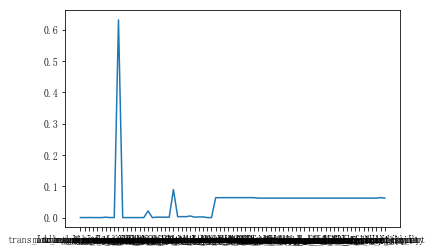

In [48]:
nan_prop = train_test.isnull().sum(axis=0)[train_test.isnull().sum(axis=0)!=0]/train_test.shape[0]
plt.plot(nan_prop)

## 缺失值处理

缺失值大概分成三类，比例在 60%，5%~10%, 1% 左右

### 缺失比例>10%

只有一列，转换成 one-hot 编码

In [49]:
nan100 = train_test[train_test.columns[train_test.isnull().sum(0)/train_test.shape[0]>0.1]]

In [50]:
nan100.columns

Index(['student_feature'], dtype='object')

In [51]:
nan100['student_feature'].value_counts()

1.0    1754
2.0       2
Name: student_feature, dtype: int64

In [52]:
def parse_student_feature(array):
    lst = [0, 0]
    if array == 1:
        lst[0] = 1
    elif array == 2:
        lst[1] = 1
    return lst

In [53]:
stu_featdf = pd.DataFrame(train_test['student_feature'].apply(parse_student_feature).values.tolist(
), columns=['student_feat_1', 'student_feat_2'])

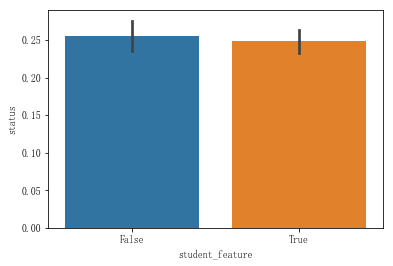

In [54]:
sns.barplot(data=pd.concat((train_test['student_feature'].isnull(), y), axis=1), x='student_feature', y='status')

student 是否缺失与逾期率相差不大

In [55]:
train_test = pd.concat((train_test.drop('student_feature', axis=1), stu_featdf), axis=1)

In [56]:
train_test.shape

(4754, 87)

## 时间特征

In [57]:
time_feat = train_test[['latest_query_time', 'loans_latest_time']]

In [58]:
train_test['latest_query_time_year'] = pd.to_datetime(train_test['latest_query_time']).dt.year
train_test['latest_query_time_month'] = pd.to_datetime(train_test['latest_query_time']).dt.month
train_test['latest_query_time_dayofyear'] = pd.to_datetime(train_test['latest_query_time']).dt.dayofyear
train_test['latest_query_time_dayofweek'] = pd.to_datetime(train_test['latest_query_time']).dt.dayofweek
train_test['latest_query_time_weekday'] =(train_test['latest_query_time_dayofweek']<=5).apply(int)

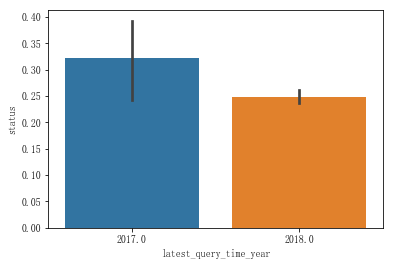

In [59]:
sns.barplot(data=pd.concat(
    (train_test['latest_query_time_year'], y), axis=1), x='latest_query_time_year', y='status')

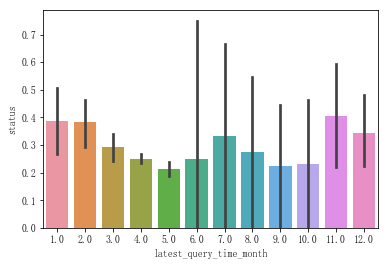

In [60]:
sns.barplot(data=pd.concat(
    (train_test['latest_query_time_month'], y), axis=1), x='latest_query_time_month', y='status')

In [61]:
train_test['loans_latest_time_year'] = pd.to_datetime(train_test['loans_latest_time']).dt.year
train_test['loans_latest_time_month'] = pd.to_datetime(train_test['loans_latest_time']).dt.month
train_test['loans_latest_time_dayofyear'] = pd.to_datetime(train_test['loans_latest_time']).dt.dayofyear
train_test['loans_latest_time_dayofweek'] = pd.to_datetime(train_test['loans_latest_time']).dt.dayofweek
train_test['loans_latest_time_weekday'] =(train_test['loans_latest_time_dayofweek']<=5).apply(int)

In [62]:
train_test['interval_query_loan_time'] = pd.to_datetime(
    train_test['latest_query_time'])-pd.to_datetime(train_test['loans_latest_time'])
train_test['interval_query_loan_time'] = train_test['interval_query_loan_time'].apply(lambda x:x.days)

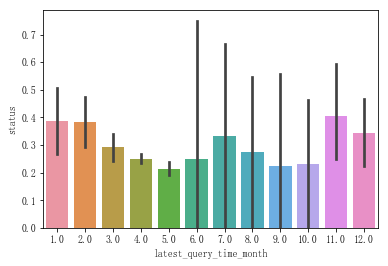

In [63]:
sns.barplot(data=pd.concat(
    (train_test['latest_query_time_month'], y), axis=1), x='latest_query_time_month', y='status')

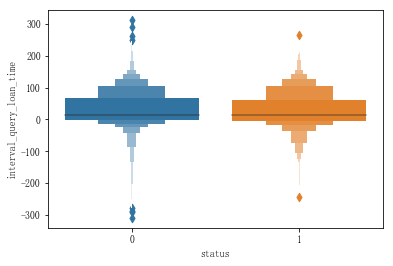

In [64]:
sns.boxenplot(data=pd.concat(
    (train_test['interval_query_loan_time'], y), axis=1), y='interval_query_loan_time', x='status')

In [65]:
train_test.drop(['loans_latest_time', 'latest_query_time'], axis=1, inplace=True)

特征工程之前的 AUC score

In [66]:
def missing(df, cols):
    for c in cols:
        df[c] = df[c].fillna(df[c].mode()[0]).astype('float')
    return df

In [67]:
train_test.shape

(4754, 96)

In [68]:
traintest_nomiss = missing(train_test, train_test.columns)
x_train, x_test, y_train, y_test = train_test_split(traintest_nomiss, y, test_size=0.2, random_state=2018)
x_train = minmax_scale(x_train)
x_test = minmax_scale(x_test)
log_reg = LogisticRegression()
lr_model = SklearnWrapper(log_reg)
lr_model.fit(x_train, y_train)
y_train_pred = lr_model.predict(x_train)
lr_model.report(y_train, y_train_pred)
y_test_pred = lr_model.predict(x_test)
lr_model.report(y_test, y_test_pred)

LogisticRegression report：
              precision    recall  f1-score   support

          0       0.81      0.96      0.88      2844
          1       0.75      0.32      0.45       959

avg / total       0.79      0.80      0.77      3803

LogisticRegression AUC：
 0.640735705412782
LogisticRegression report：
              precision    recall  f1-score   support

          0       0.82      0.90      0.86       717
          1       0.55      0.39      0.46       234

avg / total       0.75      0.77      0.76       951

LogisticRegression AUC：
 0.6428405392840538


第一次处理特征数量 96 个，AUC 0.64。

# 特征工程

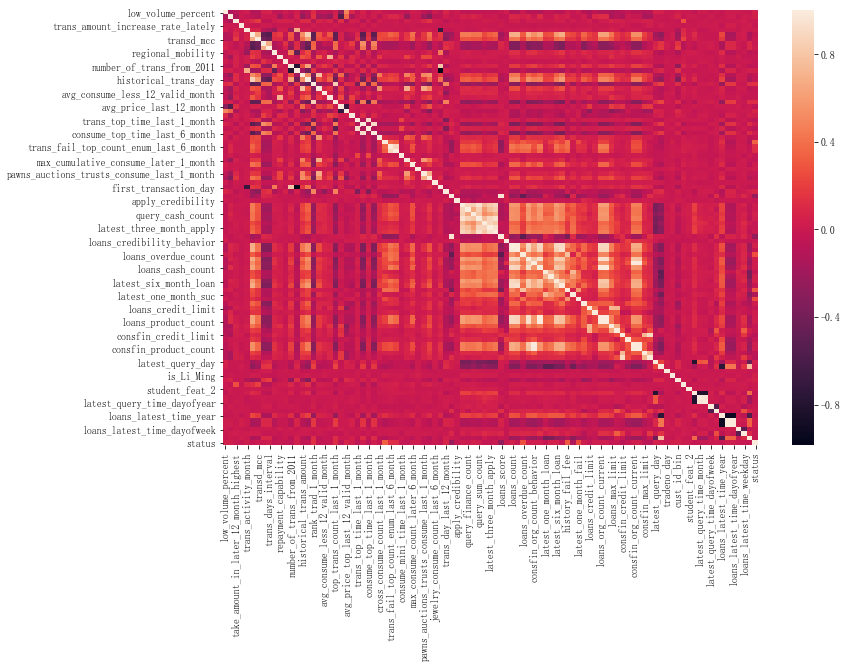

In [69]:
corr_mat = pd.concat((train_test, y), axis=1).corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_mat)

In [70]:
corr_mat.loc['status'].sort_values(ascending=False)

status                                        1.000000
trans_fail_top_count_enum_last_1_month        0.333339
history_fail_fee                              0.306273
loans_overdue_count                           0.266961
latest_one_month_fail                         0.248837
rank_trad_1_month                             0.146643
trans_fail_top_count_enum_last_6_month        0.134436
trans_fail_top_count_enum_last_12_month       0.118328
top_trans_count_last_1_month                  0.117299
trans_day_last_12_month                       0.078974
avg_price_top_last_12_valid_month             0.071259
latest_six_month_loan                         0.060227
latest_query_day                              0.057419
cust_id_bin                                   0.054846
query_cash_count                              0.053036
low_volume_percent                            0.051911
latest_three_month_loan                       0.051411
loans_count                                   0.046899
is_Li_Ming

## 相关性强的特征

### 类别特征

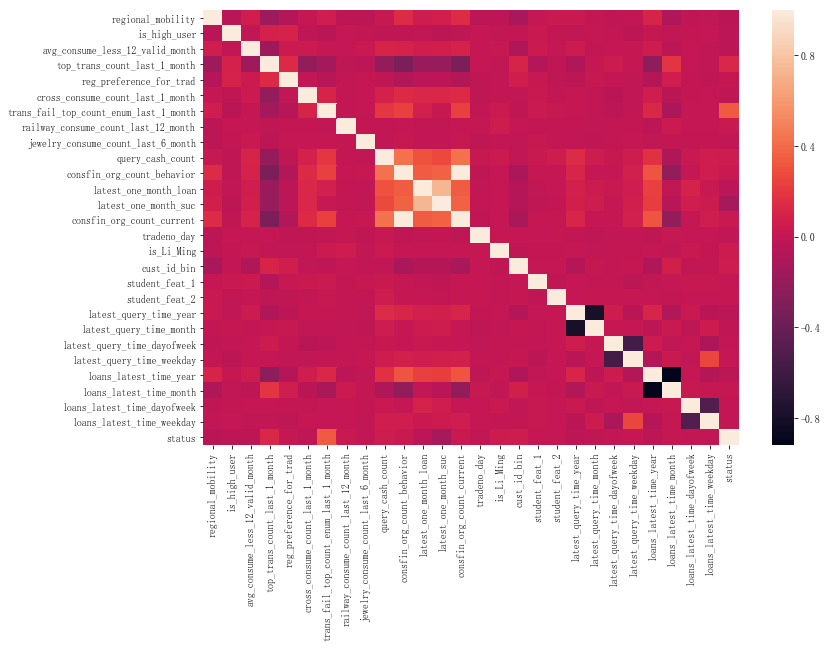

In [71]:
# nunique 小于 20 的 相关性系数
cat_cols = train_test.nunique()[train_test.nunique()<20].index
cat_train_test = train_test[cat_cols]
corr_mat = pd.concat((cat_train_test, y), axis=1).corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_mat)

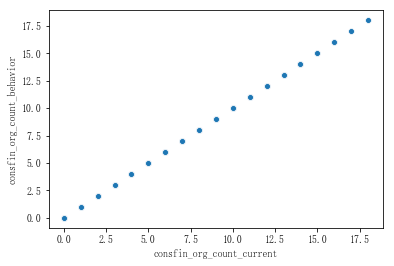

In [72]:
sns.scatterplot(train_test['consfin_org_count_current'], train_test['consfin_org_count_behavior'])

consfin_org_count_current 和 consfin_org_count_behavior 相关性系数非常高，数据相同，删除一个特征，  
并没有发现与 status 相关系数特别高的类别特征

In [73]:
train_test.drop('consfin_org_count_current', axis=1, inplace=True)

### 数值特征

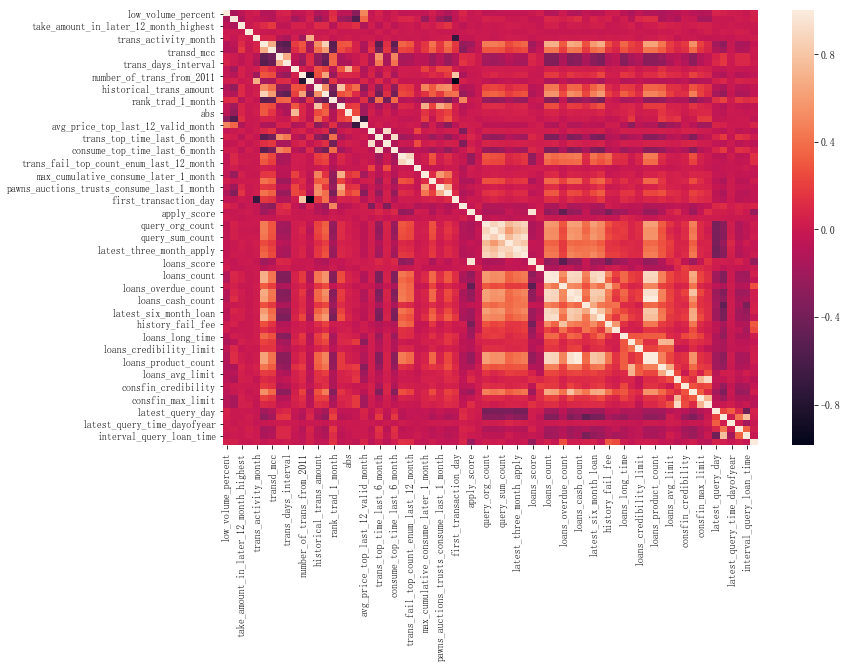

In [74]:
# nunique 大于 20 的 相关性系数
cat_cols = train_test.nunique()[train_test.nunique()>=20].index
cat_train_test = train_test[cat_cols]
corr_mat = pd.concat((cat_train_test, y), axis=1).corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_mat)

In [75]:
high_corrs = []
for i in range(corr_mat.shape[0]):
    for j in range(i, corr_mat.shape[1]):
        if corr_mat.values[i][j] >0.9 or corr_mat.values[i][j] <-0.9:
            if i != j:
                high_corrs.append((corr_mat.index[i], corr_mat.columns[j]))

In [76]:
high_corrs

[('first_transaction_time', 'first_transaction_day'),
 ('trans_top_time_last_1_month', 'consume_top_time_last_1_month'),
 ('trans_top_time_last_6_month', 'consume_top_time_last_6_month'),
 ('apply_score', 'loans_score'),
 ('query_org_count', 'query_sum_count'),
 ('query_sum_count', 'latest_six_month_apply'),
 ('latest_three_month_apply', 'latest_six_month_apply'),
 ('loans_count', 'loans_settle_count'),
 ('loans_count', 'loans_org_count_behavior'),
 ('loans_count', 'history_suc_fee'),
 ('loans_settle_count', 'history_suc_fee'),
 ('loans_org_count_behavior', 'loans_cash_count'),
 ('loans_org_count_behavior', 'loans_org_count_current'),
 ('loans_org_count_behavior', 'loans_product_count'),
 ('loans_cash_count', 'loans_org_count_current'),
 ('loans_cash_count', 'loans_product_count'),
 ('loans_org_count_current', 'loans_product_count'),
 ('consfin_credit_limit', 'consfin_avg_limit')]

上述特征之间的相关系数大于 0.9

In [77]:
def scatter_corr(idx, ax):
    c1, c2 = high_corrs[idx]
    sns.scatterplot(train_test[c1], train_test[c2], ax=ax)

In [78]:
len(high_corrs)

18

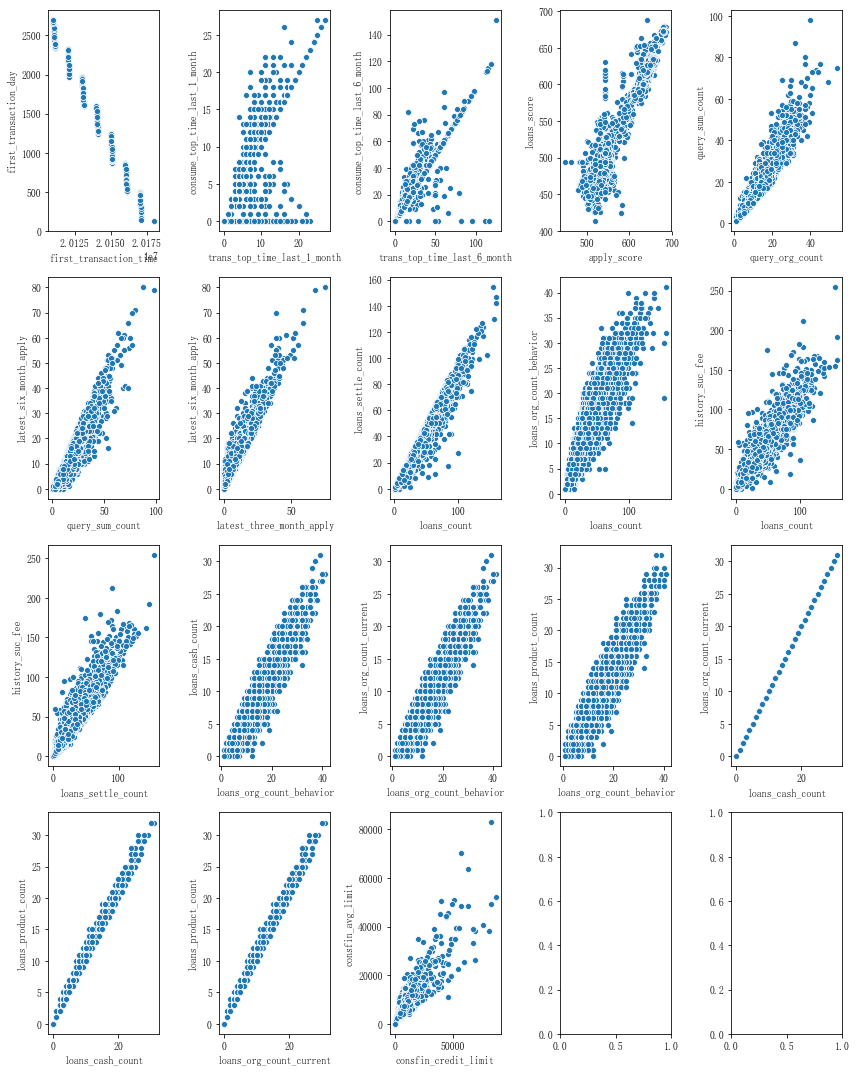

In [79]:
fig, axes = plt.subplots(4, 5, figsize=(12, 15))
axes = [j for i in axes for j in i]
for i in range(len(high_corrs)):
    scatter_corr(i, axes[i])
plt.tight_layout()

In [80]:
high_corrs097 = []
for i in range(corr_mat.shape[0]):
    for j in range(i, corr_mat.shape[1]):
        if corr_mat.values[i][j] >0.97 or corr_mat.values[i][j] <-0.97:
            if i != j:
                high_corrs097.append((corr_mat.index[i], corr_mat.columns[j]))

In [81]:
high_corrs097

[('first_transaction_time', 'first_transaction_day'),
 ('loans_count', 'loans_settle_count'),
 ('loans_cash_count', 'loans_org_count_current'),
 ('loans_cash_count', 'loans_product_count'),
 ('loans_org_count_current', 'loans_product_count')]

In [82]:
to_del_highcorr = ['first_transaction_day', 'apply_score',
                   'loans_settle_count', 'loans_org_count_current', 'loans_product_count']

In [83]:
train_test.drop(['loans_org_count_current', 'loans_cash_count', 'first_transaction_day', 'apply_score'], axis=1, inplace=True)

In [84]:
traintest_nomiss = missing(train_test, train_test.columns)
x_train, x_test, y_train, y_test = train_test_split(traintest_nomiss, y, test_size=0.2, random_state=2018)
x_train = minmax_scale(x_train)
x_test = minmax_scale(x_test)
log_reg = LogisticRegression()
lr_model = SklearnWrapper(log_reg)
lr_model.fit(x_train, y_train)
y_train_pred = lr_model.predict(x_train)
lr_model.report(y_train, y_train_pred)
y_test_pred = lr_model.predict(x_test)
lr_model.report(y_test, y_test_pred)

LogisticRegression report：
              precision    recall  f1-score   support

          0       0.81      0.96      0.88      2844
          1       0.75      0.32      0.45       959

avg / total       0.79      0.80      0.77      3803

LogisticRegression AUC：
 0.6423058844406899
LogisticRegression report：
              precision    recall  f1-score   support

          0       0.82      0.91      0.86       717
          1       0.57      0.38      0.45       234

avg / total       0.76      0.78      0.76       951

LogisticRegression AUC：
 0.6413117333619426


## 删除方差很小的特征

对于数值特征来说，方差小于 0.02 的特征数值几乎不发生变化，对模型没有作用

In [85]:
train_test[train_test.columns[train_test.nunique()>50]].var(0).sort_values()

middle_volume_percent                         2.097776e-02
trans_activity_day                            2.896606e-02
trans_activity_month                          3.877745e-02
latest_three_month_apply                      5.637315e+01
latest_six_month_apply                        8.294810e+01
number_of_trans_from_2011                     1.011328e+02
latest_six_month_loan                         1.157018e+02
query_sum_count                               1.223616e+02
trans_top_time_last_6_month                   1.678200e+02
consume_top_time_last_6_month                 1.720799e+02
trans_days_interval                           2.713278e+02
trans_day_last_12_month                       3.635298e+02
loans_settle_count                            4.511857e+02
trans_days_interval_filter                    5.158195e+02
loans_count                                   5.848436e+02
history_fail_fee                              6.085127e+02
history_suc_fee                               8.686704e+

In [86]:
train_test[["middle_volume_percent", 'trans_activity_day', 'trans_activity_month']].describe()

,middle_volume_percent,trans_activity_day,trans_activity_month
count,4754.000000,4754.000000,4754.000000
mean,0.901332,0.365356,0.804493
std,0.144837,0.170194,0.196920
min,0.000000,0.033000,0.120000
25%,0.880000,0.233000,0.670000
50%,0.960000,0.350000,0.860000
75%,0.990000,0.479500,1.000000
max,1.000000,0.941000,1.000000


这三个值得方差小，因为他们是小数，考虑处理一下小数情况

## 连续特征离散化

In [87]:
train_test.shape

(4754, 91)

### 处理 [0, 1] 的小数（二值化）

In [88]:
numpercent_tr_te = train_test[train_test.columns[(
    train_test.min() >= 0) & (train_test.max() <= 1)][:7]]

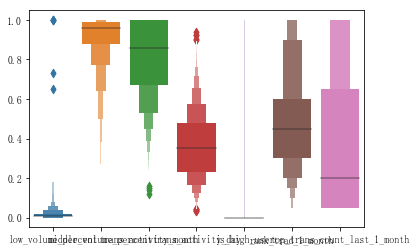

In [89]:
sns.boxenplot(data=numpercent_tr_te)

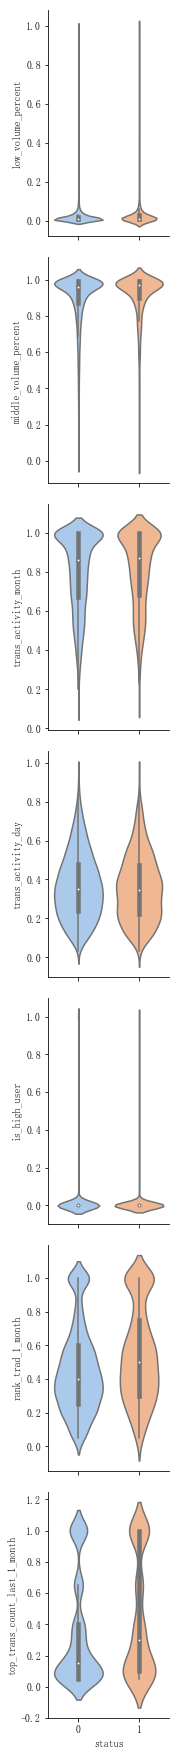

In [90]:
g = sns.PairGrid(pd.concat((numpercent_tr_te, y), axis=1),
                 x_vars=['status'],
                 y_vars=numpercent_tr_te.columns,
                 aspect=.75, height=3.5)
g.map(sns.violinplot, palette="pastel")

两个 label 下，数值分布基本是一致的。  
把小数用二值化表示，防止过拟合

In [91]:
bins=[0.02, 0.95, 0.9, 0.3, 0.4, 0.15, 0.5]

In [92]:
for i, v in enumerate(numpercent_tr_te.columns):
    numpercent_tr_te[v] = np.where(numpercent_tr_te[v]>bins[i], 1, 0)

In [93]:
train_test[numpercent_tr_te.columns] = numpercent_tr_te

In [94]:
traintest_nomiss = missing(train_test, train_test.columns)
x_train, x_test, y_train, y_test = train_test_split(traintest_nomiss, y, test_size=0.2, random_state=2018)
x_train = minmax_scale(x_train)
x_test = minmax_scale(x_test)
log_reg = LogisticRegression()
lr_model = SklearnWrapper(log_reg)
lr_model.fit(x_train, y_train)
y_train_pred = lr_model.predict(x_train)
lr_model.report(y_train, y_train_pred)
y_test_pred = lr_model.predict(x_test)
lr_model.report(y_test, y_test_pred)

LogisticRegression report：
              precision    recall  f1-score   support

          0       0.81      0.97      0.88      2844
          1       0.76      0.31      0.44       959

avg / total       0.79      0.80      0.77      3803

LogisticRegression AUC：
 0.6369344605623827
LogisticRegression report：
              precision    recall  f1-score   support

          0       0.81      0.91      0.86       717
          1       0.55      0.35      0.43       234

avg / total       0.75      0.77      0.75       951

LogisticRegression AUC：
 0.6299306226084469


### 处理整数

从与 status 最相关的几个特征入手

#### trans_fail_top_count_enum_last_1_month

主要处理思路分箱计数，违约率排名

In [95]:
train_test['trans_fail_top_count_enum_sum'] = train_test['trans_fail_top_count_enum_last_1_month'] + \
    train_test['trans_fail_top_count_enum_last_6_month'] + \
    train_test['trans_fail_top_count_enum_last_12_month']

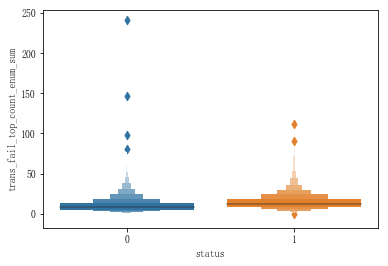

In [96]:
sns.boxenplot(data=pd.concat(
    (train_test['trans_fail_top_count_enum_sum'], y), axis=1), y='trans_fail_top_count_enum_sum', x='status')

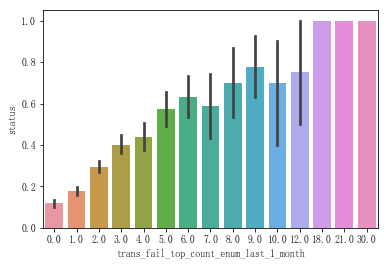

In [97]:
sns.barplot(data=pd.concat((train_test, y), axis=1), y='status', x='trans_fail_top_count_enum_last_1_month')

In [98]:
# 类别违约排名
def cat_rank(train_test, train_set, col):
    df_rank = train_set.groupby(col)['status'].mean().reset_index()
    df_rank[col + '_rank'] = df_rank['status'].rank()
    df_rank.drop('status', axis=1, inplace=True)
    train_test = pd.merge(train_test, df_rank, on=col, how='left')
    return train_test

# 类别违约率
def cat_ratio(train_test, train_set, col):
    df_ratio = train_set.groupby(col)['status'].mean().reset_index()
    df_ratio[col + '_ratio'] = df_ratio['status']
    df_ratio.drop('status', axis=1, inplace=True)
    train_test = pd.merge(train_test, df_ratio, on=col, how='left')
    return train_test

In [99]:
# 类别分箱及统计
def cat_bins_count(train_test, col, bins):
    train_test[col+'_bins'] = pd.cut(train_test[col], bins=bins, right=False, labels=[str(i) for i in bins][1:])
    train_test[col+'_bincount'] = train_test.groupby(col+'_bins')[col].transform('count')

In [100]:
bins=list(range(0, 10))+[40]

In [101]:
cat_bins_count(train_test, 'trans_fail_top_count_enum_sum', bins)

In [102]:
train_test = cat_rank(train_test, pd.concat((train_test, y), axis=1), 'trans_fail_top_count_enum_sum_bins')

#### history_fail_fee

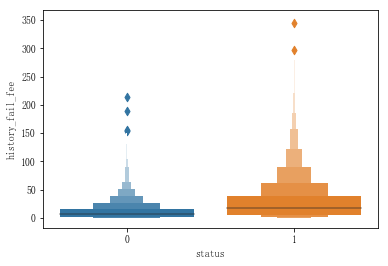

In [103]:
sns.boxenplot(data=pd.concat((train_test, y), axis=1), x='status', y='history_fail_fee')

In [104]:
pd.concat((train_test, y), axis=1)[pd.concat((train_test, y), axis=1)['history_fail_fee']>100]['status'].mean()

0.7625

In [105]:
bins = list(range(0, 100, 10)) + [500]

对 history_fail_fee 进行分箱，统计每个箱子内的个数及违约率排名

In [106]:
cat_bins_count(train_test, 'history_fail_fee', bins)

train_test = cat_rank(train_test, pd.concat((train_test, y), axis=1), 'history_fail_fee_bins')

#### loans_overdue_count

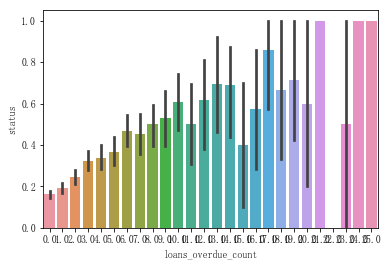

In [107]:
sns.barplot(data=pd.concat((train_test, y), axis=1), x='loans_overdue_count', y='status')

In [108]:
pd.concat((train_test, y), axis=1)[pd.concat((train_test, y), axis=1)['loans_overdue_count']>8]['status'].mean()

0.5921052631578947

In [109]:
bins = list(range(0, 11)) + [30]

In [110]:
cat_bins_count(train_test, 'loans_overdue_count', bins)

train_test = cat_rank(train_test, pd.concat((train_test, y), axis=1), 'loans_overdue_count_bins')

#### latest_one_month_fail

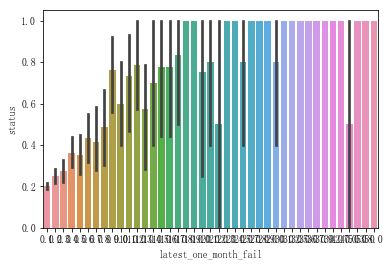

In [111]:
sns.barplot(data=pd.concat((train_test, y), axis=1), x='latest_one_month_fail', y='status')

In [112]:
pd.concat((train_test, y), axis=1)[pd.concat((train_test, y), axis=1)['latest_one_month_fail']>6]['status'].mean()

0.7276995305164319

In [113]:
bins = list(range(0, 14)) + [100]

In [114]:
cat_bins_count(train_test, 'latest_one_month_fail', bins)

train_test = cat_rank(train_test, pd.concat(
    (train_test, y), axis=1), 'latest_one_month_fail_bins')

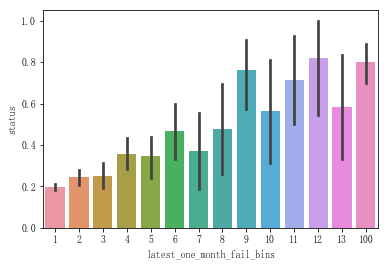

In [115]:
sns.barplot(data=pd.concat(
    (train_test[:x_train.shape[0]], y), axis=1), x='latest_one_month_fail_bins', y='status')

#### loans_score

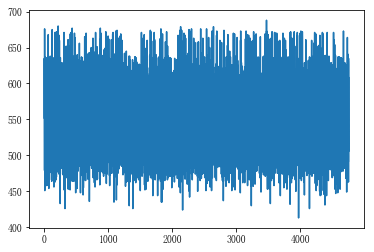

In [116]:
plt.plot(train_test['loans_score'])

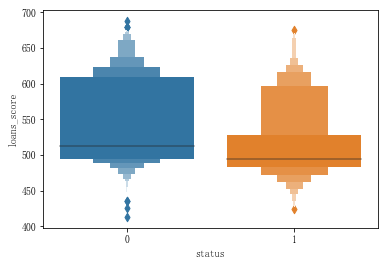

In [117]:
sns.boxenplot(data=pd.concat((train_test['loans_score'], y), axis=1), y='loans_score', x='status')

In [118]:
bins = list(range(400, 750, 50))

In [119]:
cat_bins_count(train_test, 'loans_score', bins)

In [120]:
train_test = cat_rank(train_test, pd.concat((train_test, y), axis=1)[
                      :x_train.shape[0]], 'loans_score_bins')

In [121]:
traintest_nomiss = missing(train_test, train_test.columns)
x_train, x_test, y_train, y_test = train_test_split(traintest_nomiss, y, test_size=0.2, random_state=2018)
x_train = minmax_scale(x_train)
x_test = minmax_scale(x_test)
log_reg = LogisticRegression()
lr_model = SklearnWrapper(log_reg)
lr_model.fit(x_train, y_train)
y_train_pred = lr_model.predict(x_train)
lr_model.report(y_train, y_train_pred)
y_test_pred = lr_model.predict(x_test)
lr_model.report(y_test, y_test_pred)

LogisticRegression report：
              precision    recall  f1-score   support

          0       0.82      0.95      0.88      2844
          1       0.72      0.36      0.48       959

avg / total       0.79      0.80      0.78      3803

LogisticRegression AUC：
 0.6583959571694027
LogisticRegression report：
              precision    recall  f1-score   support

          0       0.82      0.92      0.86       717
          1       0.60      0.37      0.46       234

avg / total       0.76      0.78      0.76       951

LogisticRegression AUC：
 0.6447537817830704


# 交叉特征

## 高相关或低相关的统计量

In [122]:
corrs = pd.concat((train_test, y), axis=1).corr().loc['status'].sort_values(ascending=False)

所有 rank 的平均数，最大值
bool 特征的加和

rank 的平均数/最大值

In [123]:
ranks = ['trans_fail_top_count_enum_sum_bins_rank', 'history_fail_fee_bins_rank',
         'loans_overdue_count_bins_rank', 'latest_one_month_fail_bins_rank', 'loans_score_bins_rank']

In [124]:
train_test['corr_rank_sum'] = train_test[ranks].sum(1)
train_test['corr_rank_max'] = train_test[ranks].max(1)

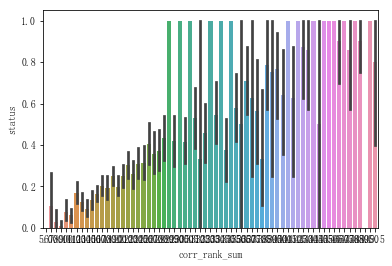

In [125]:
sns.barplot(data=pd.concat((train_test, y), axis=1), x='corr_rank_sum', y='status')

In [126]:
bincounts = ['latest_one_month_fail_bincount', 'loans_overdue_count_bincount',
            'history_fail_fee_bincount', 'trans_fail_top_count_enum_sum_bincount']

In [127]:
train_test['bin_counts_sum'] = train_test[bincounts].sum(1)

## 高相关的交叉特征

In [129]:
corr_mat = pd.concat((train_test, y)[:x_train.shape[0]], axis=1).corr()

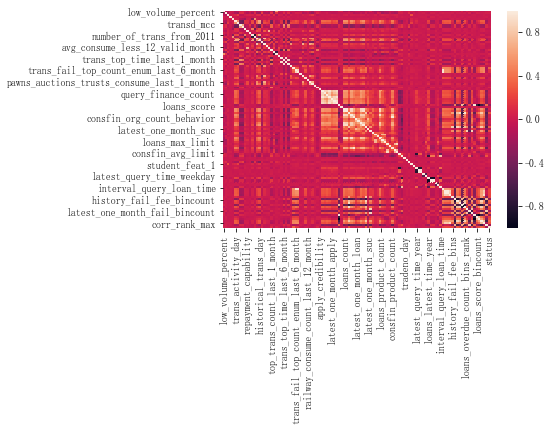

In [130]:
sns.heatmap(corr_mat)

相关系数 >0.85 的特征

In [131]:
high_corrs = []
for i in range(corr_mat.shape[0]):
    for j in range(i, corr_mat.shape[1]):
        if corr_mat.values[i][j] >0.85 or corr_mat.values[i][j] <-0.85:
            if i != j:
                high_corrs.append((corr_mat.index[i], corr_mat.columns[j]))

In [132]:
def scatter_corr2(idx, ax):
    c1, c2 = high_corrs[idx]
    sns.scatterplot(data=pd.concat((train_test[:x_train.shape[0]], y), axis=1), x=c1, y=c2, ax=ax, hue='status')

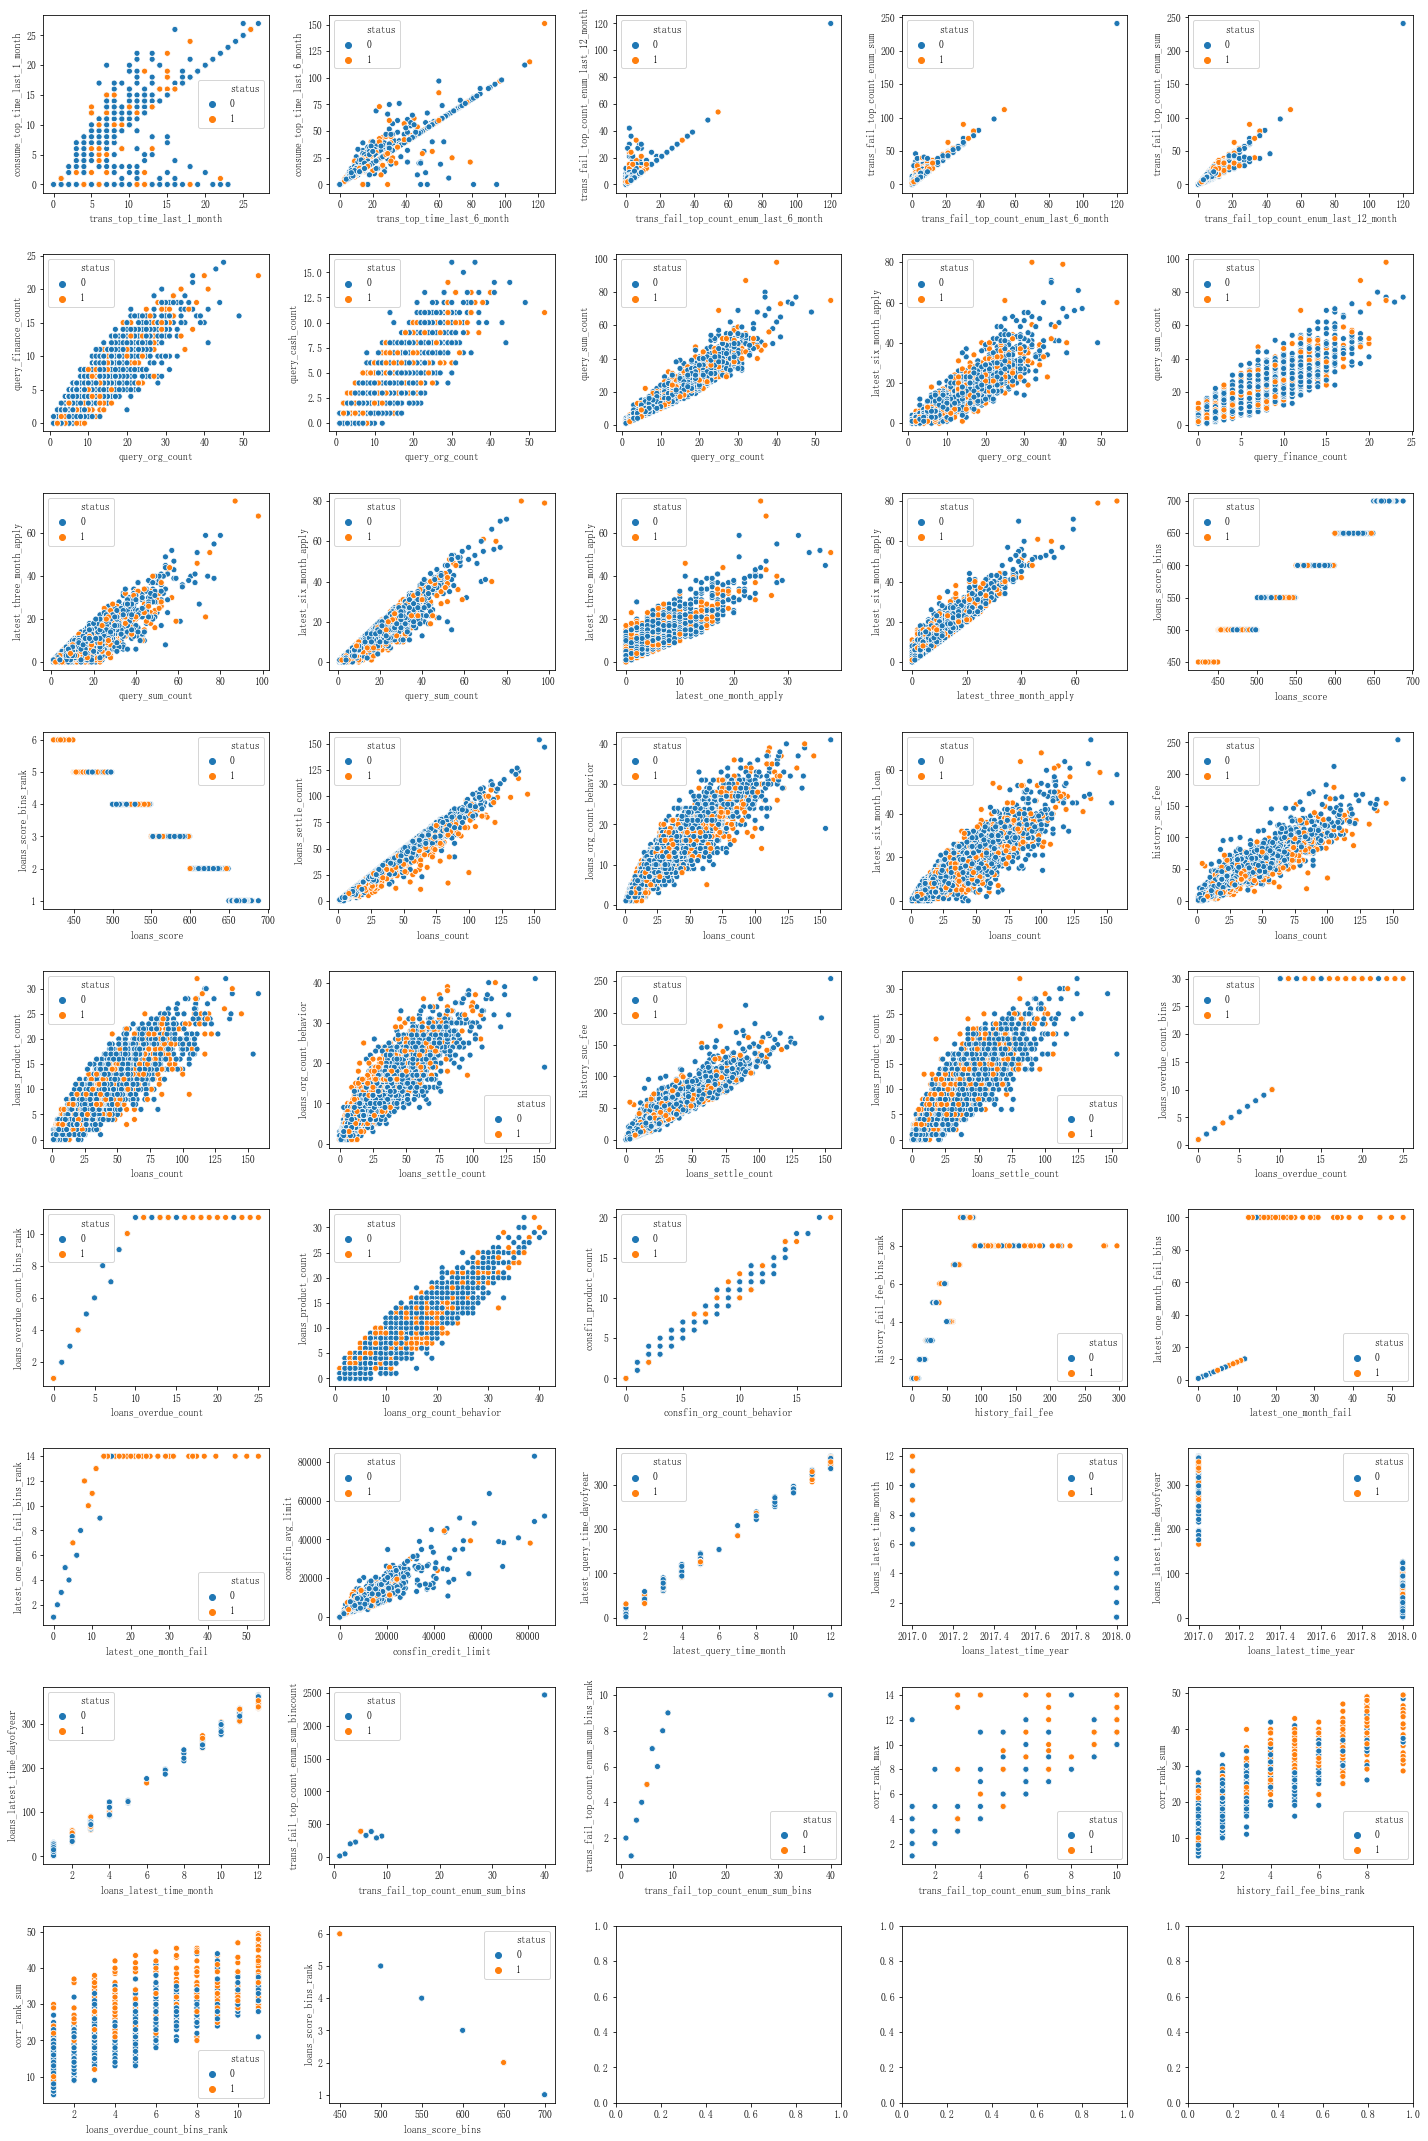

In [133]:
fig, axes = plt.subplots(9, 5, figsize=(20, 30))
axes = [j for i in axes for j in i]
for i in range(42):
    scatter_corr2(i, axes[i])
plt.tight_layout()

找出 label = 1 和 0 中分布不一致的做交叉

In [135]:
cross_feat = ['trans_top_time_last_6_month/consume_top_time_last_6_month', 'trans_fail_top_count_enum_last_12_month/trans_fail_top_count_enum_last_6_month',
              'loans_settle_count/loans_count', 'history_suc_fee/loans_count', 'loans_org_count_behavior/loans_settle_count', 'loans_credit_limit+loans_avg_limit',
             'loans_overdue_count_bins/loans_overdue_count', 'loans_overdue_count_bins_rank/loans_overdue_count', 
             'latest_one_month_fail_bins/latest_one_month_fail']

In [136]:
for i in cross_feat:
    if '/' in i:
        f1, f2 = i.split('/')
        train_test[i] = train_test[f1] / (train_test[f2]+0.001)
    elif '+' in i:
        f1, f2 = i.split('+')
        train_test[i] = train_test[f1] + train_test[f2]

In [138]:
traintest_nomiss = missing(train_test, train_test.columns)
x_train, x_test, y_train, y_test = train_test_split(traintest_nomiss, y, test_size=0.2, random_state=2018)

x_train = minmax_scale(x_train)
x_test = minmax_scale(x_test)
log_reg = LogisticRegression()
lr_model = SklearnWrapper(log_reg)
lr_model.fit(x_train, y_train)
y_train_pred = lr_model.predict(x_train)
lr_model.report(y_train, y_train_pred)
y_test_pred = lr_model.predict(x_test)
lr_model.report(y_test, y_test_pred)

LogisticRegression report：
              precision    recall  f1-score   support

          0       0.82      0.95      0.88      2844
          1       0.71      0.37      0.49       959

avg / total       0.79      0.80      0.78      3803

LogisticRegression AUC：
 0.661512116319009
LogisticRegression report：
              precision    recall  f1-score   support

          0       0.82      0.91      0.86       717
          1       0.59      0.38      0.46       234

avg / total       0.76      0.78      0.76       951

LogisticRegression AUC：
 0.6462378857776347


# 特征重要性

利用 xgb 选择特征时，可以从特征 Gini 增益，特征分裂次数，特征所在的平均深度，特征是否被使用，特征子节点样本数量等方面考虑。  
利用 xgbfir 可以直接计算特征重要性的属性值。

In [160]:
import xgboost as xgb
xgb_cmodel = xgb.XGBClassifier().fit(train_test[:x_train.shape[0]].astype('float'), y_train)

In [161]:
xgbfir.saveXgbFI(xgb_cmodel, feature_names=train_test.columns, OutputXlsxFile='特征重要性.xlsx')

In [162]:
fi = pd.read_excel('特征重要性.xlsx')

In [163]:
selected_feats = fi.sort_values(by='Average Rank')[:80]['Interaction']

In [164]:
train_test_select = train_test[selected_feats]

# 模型预测和评估

In [165]:
train_test_select.shape

(4754, 80)

In [186]:
x_train, x_test, y_train, y_test = train_test_split(train_test_select, y, test_size=0.2, random_state=2018)

## LR

In [192]:
def print_result(model, x_train, y_train, x_test):
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    print('----Training Report----')
    model.report(y_train, y_train_pred)
    print('----Test Report----')
    y_test_pred = model.predict(x_test)
    model.report(y_test, y_test_pred)

In [193]:
x_train_scale = minmax_scale(x_train)
x_test_scale = minmax_scale(x_test)

In [194]:
log_reg = LogisticRegression()
lr_model = SklearnWrapper(log_reg)
print_result(lr_model, x_train_scale, y_train, x_test_scale)

----Training Report----
LogisticRegression report：
              precision    recall  f1-score   support

          0       0.81      0.95      0.87      2844
          1       0.68      0.32      0.44       959

avg / total       0.77      0.79      0.76      3803

LogisticRegression AUC：
 0.6356130536233096
----Test Report----
LogisticRegression report：
              precision    recall  f1-score   support

          0       0.80      0.94      0.86       717
          1       0.59      0.28      0.38       234

avg / total       0.75      0.77      0.74       951

LogisticRegression AUC：
 0.6075081357508135


## 决策树

In [196]:
dtree = DecisionTreeClassifier(max_depth=6)
dtreemodel = SklearnWrapper(dtree)
print_result(dtreemodel, x_train, y_train, x_test)

----Training Report----
DecisionTreeClassifier report：
              precision    recall  f1-score   support

          0       0.84      0.95      0.89      2844
          1       0.76      0.47      0.58       959

avg / total       0.82      0.83      0.81      3803

DecisionTreeClassifier AUC：
 0.7082722860926687
----Test Report----
DecisionTreeClassifier report：
              precision    recall  f1-score   support

          0       0.80      0.90      0.85       717
          1       0.50      0.29      0.37       234

avg / total       0.72      0.75      0.73       951

DecisionTreeClassifier AUC：
 0.5993187426241819


## SVC

In [ ]:
LinearSVC = SVC(kernel='linear', probability=True).fit(x_train, y_train)
svcmodel = SklearnWrapper(LinearSVC)
print_result(svcmodel, x_train_scale, y_train, x_test_scale)

## LightGBM

In [ ]:
lgbmClassifier = LGBMClassifier()
lgbmodel = SklearnWrapper(lgbmClassifier)
print_result(lgbmodel, x_train, y_train, x_test)

## lgbmClassifier

In [180]:
xgbClassifier = XGBClassifier()
xgbmodel = SklearnWrapper(xgbClassifier)
print_result(xgbmodel, x_train, y_train, x_tst)

----Training Report----
LogisticRegression report：
              precision    recall  f1-score   support

          0       0.82      0.95      0.88      2844
          1       0.71      0.37      0.49       959

avg / total       0.79      0.80      0.78      3803

LogisticRegression AUC：
 0.661512116319009
----Test Report----
LogisticRegression report：
              precision    recall  f1-score   support

          0       0.82      0.91      0.86       717
          1       0.59      0.38      0.46       234

avg / total       0.76      0.78      0.76       951

LogisticRegression AUC：
 0.6462378857776347
